In [78]:
import qdrant_client
from llama_index.core import SimpleDirectoryReader
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex

In [85]:
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

In [86]:
text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

In [ ]:
from datasets import load_dataset
dataset = load_dataset("KrushiJethe/fashion_data")
train_data = dataset['train'] 

In [5]:
train_data

Dataset({
    features: ['image', 'Unnamed: 0', 'articleType', 'productDisplayName', 'articleType_label'],
    num_rows: 9300
})

In [70]:
from datasets import load_dataset
from PIL import Image
from llama_index.core import Document


dataset = load_dataset("Marqo/deepfashion-multimodal", split='data')
NUM_SAMPLES = 100
subset = dataset.select(range(NUM_SAMPLES))

documents = []

Generating data split: 100%|██████████| 42537/42537 [00:00<00:00, 72691.81 examples/s]


KeyError: 'Unnamed: 0'

In [88]:
for idx, data in enumerate(subset):
    product_description = data['text']  # Assuming 'text' contains the product description
    
    image = data['image']
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    
    # Use the loop index as a unique identifier for each image
    image_path = f"images/image_{idx}.png"
    image.save(image_path) 
    
    # Create a Document object with the product description and image path
    doc = Document(text=product_description, extra_info={"image_path": image_path})
    documents.append(doc)

In [7]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.embeddings.clip import ClipEmbedding
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

In [8]:
from llama_index.core import Settings
Settings.embed_model =embed_model

In [9]:
from llama_index.embeddings.clip import ClipEmbedding
image_embed_model = ClipEmbedding()

In [89]:
from llama_index.core import SimpleDirectoryReader
from llama_index.core.indices import MultiModalVectorStoreIndex

image_documents = SimpleDirectoryReader("/Users/samvardhan/Desktop/DataEngineer/multimodal_search/llamaIndex_multimodal_example/images").load_data()
final_documents = documents + image_documents
index = MultiModalVectorStoreIndex.from_documents(
    final_documents,
    storage_context=storage_context,
    image_embed_model=image_embed_model,
)

In [11]:

from llama_index.multi_modal_llms.ollama import OllamaMultiModal
mm_model = OllamaMultiModal(model="llava:7b-v1.5-q4_1", request_timeout=200)

In [126]:
from llama_index.core.prompts import PromptTemplate
from llama_index.core.query_engine import SimpleMultiModalQueryEngine

qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)

qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(llm=mm_model, text_qa_template=qa_tmpl , verbose=True)

query_str =  "White and Brown colour sneaker "
response = query_engine.query(query_str)

In [128]:
print(str(response))

 No


In [129]:
if response.source_nodes:
    for node_with_score in response.source_nodes:
        node = node_with_score.node
        
        if hasattr(node, 'text') and node.text:
            print(f"TextNode: {node.text}")
    
        if hasattr(node, 'image_path') and node.image_path:
            print(f"ImageNode Path: {node.image_path}")
else:
    print("No source nodes found in the response.")


TextNode: The gentleman wears a tank tank top with pure color patterns. The tank top is with cotton fabric. It has a square neckline. The gentleman wears a long pants. The pants are with cotton fabric and solid color patterns.
ImageNode Path: /Users/samvardhan/Desktop/DataEngineer/multimodal_search/llamaIndex_multimodal_example/images/image_40.png
ImageNode Path: /Users/samvardhan/Desktop/DataEngineer/multimodal_search/llamaIndex_multimodal_example/images/image_38.png


In [104]:
print(str(response))

None


In [52]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

**Node ID:** 655bd290-b89d-4754-8281-79186fd61a33<br>**Similarity:** 0.7313433835678387<br>**Text:** The T-shirt this gentleman wears has short sleeves, its fabric is cotton, and it has graphic patterns. The T-shirt has a round neckline. This gentleman wears a long pants, with denim fabric and sol...<br>

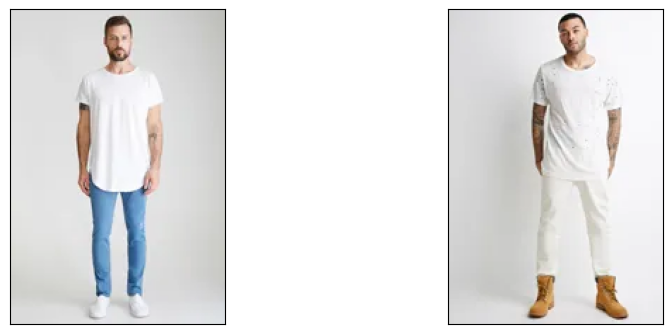

In [105]:
# show sources
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)